# Load packages and models

In [ ]:
import os
import sys
from pathlib import Path

# Erkenne, ob wir auf Colab laufen
IS_COLAB = "google.colab" in sys.modules

if IS_COLAB:
    from google.colab import drive, files

    drive.mount("/content/drive", force_remount=True)
    BASE_PATH = "/content"
    print("✓ Google Colab erkannt")
else:
    BASE_PATH = str(Path.home() / "ski_lift_data")
    os.makedirs(BASE_PATH, exist_ok=True)
    print(f"✓ Lokaler Modus: {BASE_PATH}")

In [ ]:
# select file, if not running 'live' mode
if IS_COLAB:
    print("\nÜploadiere deine Datei (optional):")
    uploaded = files.upload()

Saving take5.mov to take5.mov


✓ Using CPU for inference
Logging to: /Users/dustin/dev/computer-vision-ski-lift-wait-time-estimator/ski_cam_logs/roi_counts_20251215_142514.csv
Bergfex mode: extracting stream URL...
✓ Extracted webcam ID: 114
📍 Fetching page: https://www.bergfex.at/scheffau/webcams/c114/
📄 HTML page size: 219869 bytes
🔍 Searching for embedded Feratel WebTV links...
  ⚠️ No 'feratel' keyword in static HTML (likely JavaScript-loaded)
🔍 Searching for direct stream URLs...

💡 Attempting to construct Feratel URL from webcam data...
  ℹ️  Known Feratel cam ID for webcam 114: 5665
  🔗 Resolving Feratel page: https://webtv.feratel.com/webtv/?cam=5665
    ✓ Feratel page loaded (size: 184676 bytes)
    ✓ Found HLS stream: https://sts007.feratel.co.at/streams/stsstore004/1/05665_69400b01-c4f6Vid.mp4?dc...
Opening video stream...
✓ Stream dimensions: 1920x1080
Stream: 1920x1080, Reference: 2090x1164
ROI: (183, 463) to (872, 835)


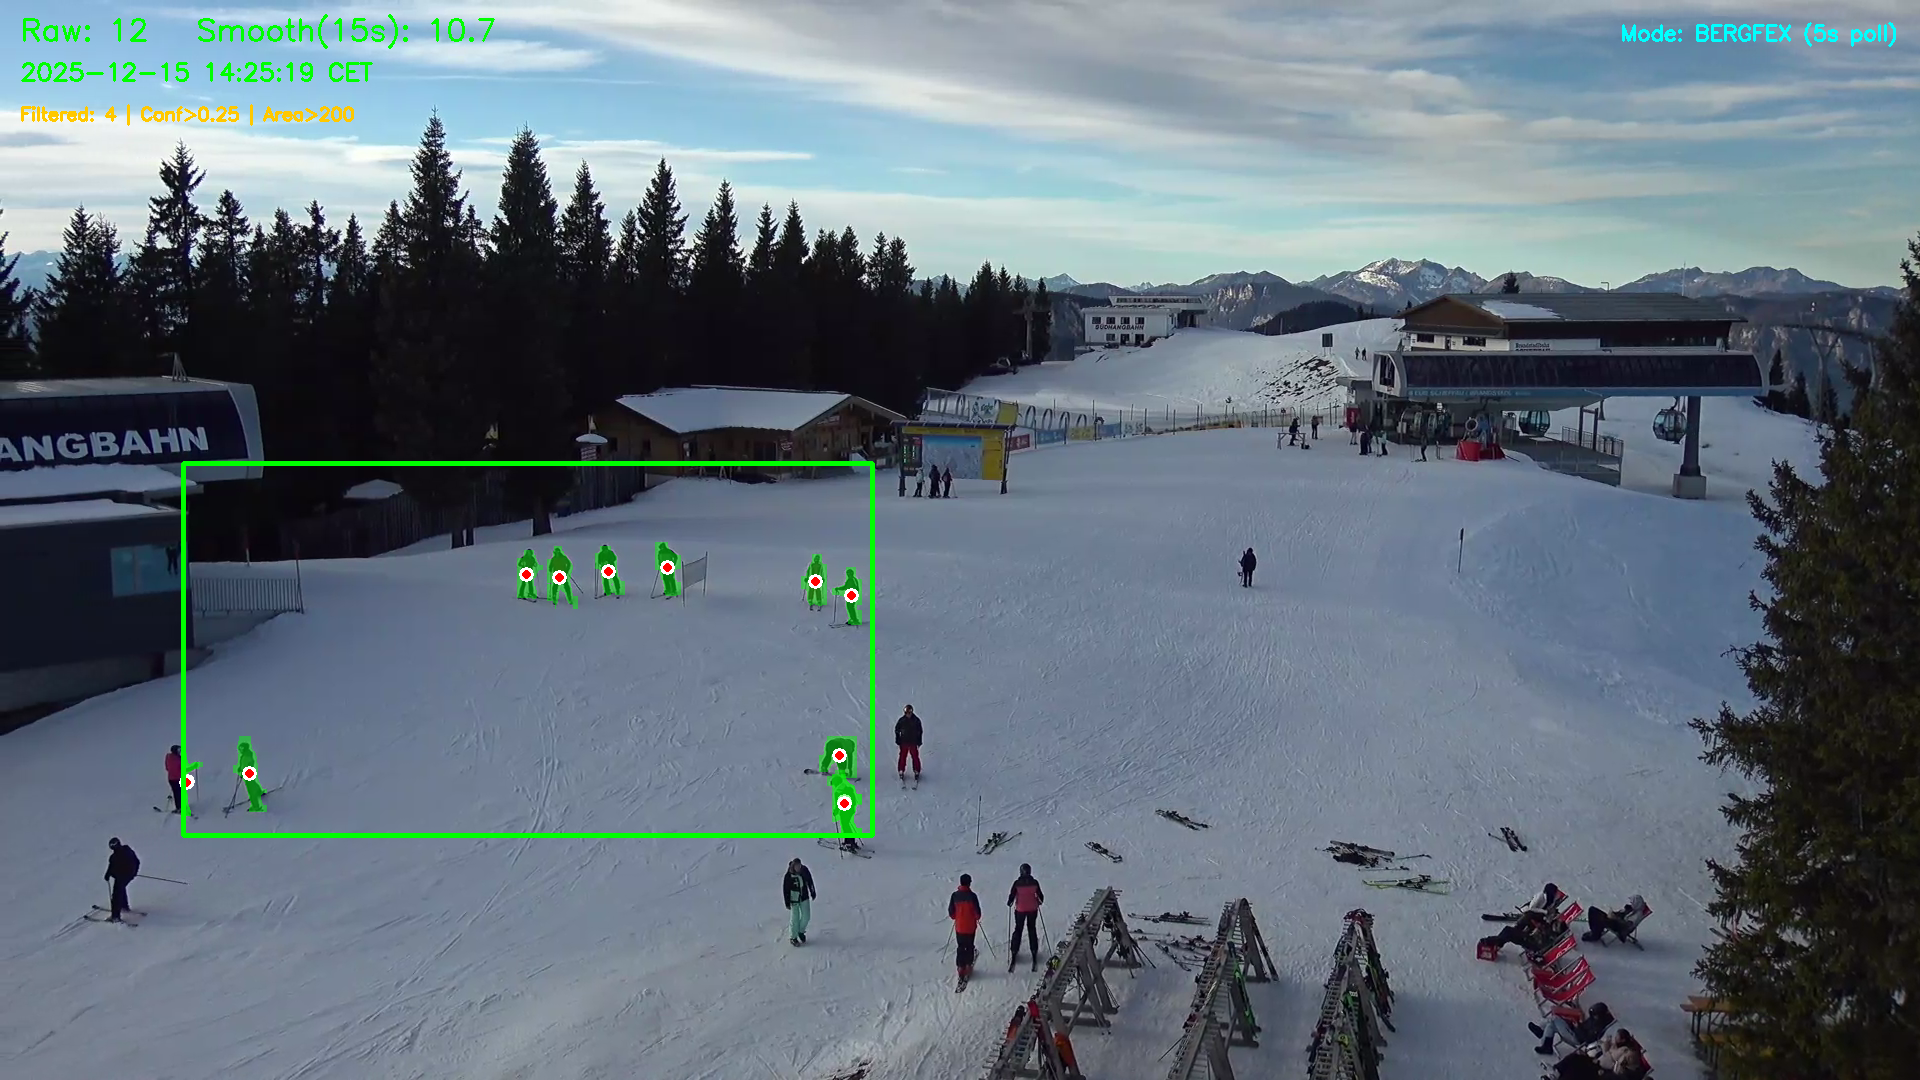


--- Frame 0 ---
Counted: 12, Filtered: 6
  #0: conf=0.83, area=1221, pos=(528, 578)
  #1: conf=0.82, area=897, pos=(494, 575)
  #2: conf=0.80, area=1011, pos=(636, 568)
  #3: conf=0.80, area=980, pos=(577, 569)
  #4: conf=0.79, area=1257, pos=(215, 777)
  #5: conf=0.78, area=981, pos=(821, 595)
  #6: conf=0.70, area=962, pos=(785, 579)
  #7: conf=0.62, area=1309, pos=(817, 803)
  #8: conf=0.62, area=1314, pos=(817, 803)
  #10: conf=0.50, area=690, pos=(866, 726)
  #14: conf=0.32, area=637, pos=(866, 730)
  #15: conf=0.30, area=1138, pos=(808, 754)
Frame 0 | FPS:5.9 | raw=12, smooth=12.0, filtered=6
Frame 1 | FPS:4.9 | raw=10, smooth=11.0, filtered=4
Frame 2 | FPS:2.6 | raw=10, smooth=10.7, filtered=5
Frame 3 | FPS:5.3 | raw=10, smooth=10.5, filtered=5
Frame 4 | FPS:4.3 | raw=11, smooth=10.6, filtered=6
Frame 5 | FPS:2.6 | raw=10, smooth=10.5, filtered=4
Frame 6 | FPS:5.0 | raw=10, smooth=10.4, filtered=5
Frame 7 | FPS:3.5 | raw=11, smooth=10.5, filtered=6
Frame 8 | FPS:5.6 | raw=11, s

KeyboardInterrupt: 

In [44]:
# ============================================================
# INSTALLS & IMPORTS
# ============================================================
# !pip install ultralytics yt-dlp streamlink -q

import cv2, time, subprocess, shlex, os, csv, datetime
import numpy as np
import pandas as pd
from ultralytics import YOLO
from IPython.display import display, clear_output, DisplayHandle
from PIL import Image
from zoneinfo import ZoneInfo
from collections import deque
import torch
import requests
from io import BytesIO
import re


# ============================================================
# SETTINGS
# ============================================================

MODE = "bergfex"  # "file", "live", "bergfex", or "feratel"

# Base paths (local-friendly)
BASE_DIR = os.getcwd()

# File mode
input_video = os.path.join(BASE_DIR, "your_video.mov")

# Live mode (YouTube)
youtube_url = "https://www.youtube.com/watch?v=wooEGQw9yrw"
COOKIES_PATH = None  # optional, for age-restricted streams

# Bergfex mode (static image polling)
bergfex_url = "https://www.bergfex.at/scheffau/webcams/c114/"  # example URL
BERGFEX_POLL_INTERVAL = 5  # seconds between image fetches

# Feratel WebTV mode (live stream)
feratel_url = "https://webtv.feratel.com/webtv/?design=v5&pg=121E2E32-862A-4791-8936-B41853615FB6&cam=5665"  # example Feratel WebTV URL
FERATEL_USE_STREAMLINK = True  # use streamlink for better stream resolution
FERATEL_USER_AGENT = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36"

# Preview (optimized for real-time)
LIVE_PREVIEW = True
PREVIEW_EVERY = 1  # show every frame for real-time preview

# Debug
DEBUG_MODE = True
DEBUG_PRINT_EVERY = 30

# Loop limits (to prevent endless loops)
MAX_FRAMES = 1200  # stop after ~10 min at 2 fps
MAX_SECONDS = 300  # stop after 5 minutes
FRAME_SKIP = 0  # skip frames for faster processing (0 = no skip)


# ============================================================
# DETECTION PARAMETERS
# ============================================================

CONF_THRESHOLD = 0.25  # higher = fewer false positives (try 0.25–0.45)
IOU_THRESHOLD = 0.9  # higher = less merging of nearby detections
MIN_MASK_AREA = 200  # filter out tiny fragments
PERSON_CLASS_ONLY = True


# ============================================================
# MODEL & GPU/CPU
# ============================================================

# Use smaller, faster model for real-time inference
model = YOLO("yolo11s-seg.pt")

# Auto-detect GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    model.to("cuda")
    print("✓ Using GPU (CUDA) for inference")
else:
    print("✓ Using CPU for inference")


# ============================================================
# ROI CONFIG
# ============================================================

# Reference resolution (what your ROI coords are based on)
REF_WIDTH = 2090
REF_HEIGHT = 1164

# ROI bounding box (adjust for your camera)
BASE_ROI_X1, BASE_ROI_Y1 = 200, 500
BASE_ROI_X2, BASE_ROI_Y2 = 950, 900

SCALE = 2.5  # upscale factor for better detection on small regions


# ============================================================
# LOGGING
# ============================================================

TZ = ZoneInfo("Europe/Berlin")
SESSION_START = datetime.datetime.now(TZ).strftime("%Y%m%d_%H%M%S")

LOG_DIR = os.path.join(BASE_DIR, "ski_cam_logs")
LOG_PATH = os.path.join(LOG_DIR, f"roi_counts_{SESSION_START}.csv")

SMOOTH_WINDOW_SEC = 15
history = deque()

os.makedirs(LOG_DIR, exist_ok=True)

log_file = open(LOG_PATH, "w", newline="")
log_writer = csv.writer(log_file)
log_writer.writerow(
    [
        "frame_idx",
        "epoch_time",
        "local_time",
        "raw_count",
        "smoothed_count",
        "filtered_out_count",
    ]
)
log_file.flush()

print(f"Logging to: {LOG_PATH}")


# ============================================================
# SCREENSHOTS (live mode only)
# ============================================================

SCREENSHOT_DIR = os.path.join(BASE_DIR, "screenshots")
os.makedirs(SCREENSHOT_DIR, exist_ok=True)

SCREENSHOT_THRESHOLD = 20
SCREENSHOT_COOLDOWN = 10
last_screenshot_time = 0.0


# ============================================================
# FERATEL WEBTV URL PARSER
# ============================================================

def extract_feratel_webtv_stream_url(page_url):
    """
    Extract HLS stream URL from Feratel WebTV page.
    The page typically contains an embedded video player with a stream URL.
    """
    try:
        # Fetch the page
        headers = {"User-Agent": FERATEL_USER_AGENT}
        response = requests.get(page_url, headers=headers, timeout=10)
        response.raise_for_status()
        
        # Extract stream URL from HTML (look for m3u8, mp4, or rtmp links)
        patterns = [
            r'"([^"]*\.m3u8[^"]*)"',  # HLS streams
            r"'([^']*\.m3u8[^']*)'",  # HLS in single quotes
            r'"([^"]*streaming[^"]*)"',  # streaming URLs
            r'"(https?://[^"]*\.mp4[^"]*)"',  # MP4 streams
        ]

        
        for pattern in patterns:
            matches = re.findall(pattern, response.text)
            print (f"Searching with pattern: {pattern}, found: {matches}")
            if matches:
                stream_url = matches[0]
                if stream_url.startswith(('http://', 'https://', '//')):
                    if stream_url.startswith('//'):
                        stream_url = 'https:' + stream_url
                    print(f"✓ Found stream URL via HTML parsing: {stream_url[:100]}...")
                    return stream_url
        
        # If HTML parsing failed, try using streamlink
        if FERATEL_USE_STREAMLINK:
            print("✓ Trying streamlink to extract stream URL...")
            cmd = f'streamlink "{page_url}" best -o -'
            print(f"Command: {cmd}")
            return f"pipe://{cmd}"  # OpenCV can sometimes handle piped input
        
        raise ValueError("Could not extract stream URL from Feratel page")
        
    except Exception as e:
        print(f"⚠️ Error extracting Feratel stream: {e}")
        raise

def extract_bergfex_stream_url(page_url):
    """
    Extract stream URL (HLS/MP4/RTMP) from bergfex webcam page.
    Also checks for embedded Feratel WebTV links (dynamically loaded content).
    Falls back to static image polling if no stream is found.
    Returns: tuple (stream_url or None, is_video_stream: bool)
    """
    try:
        # Extract webcam ID from URL
        match = re.search(r'/c(\d+)/?', page_url)
        if not match:
            raise ValueError(f"Could not extract webcam ID from URL: {page_url}")
        
        webcam_id = match.group(1)
        print(f"✓ Extracted webcam ID: {webcam_id}")
        print(f"📍 Fetching page: {page_url}")
        
        # Fetch the page with headers
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36",
            "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
        }
        
        # Try to get the page
        try:
            response = requests.get(page_url, headers=headers, timeout=10)
            response.raise_for_status()
            html_content = response.text
            print(f"📄 HTML page size: {len(html_content)} bytes")
        except Exception as e:
            print(f"⚠️ Could not fetch Bergfex page: {type(e).__name__}: {e}")
            html_content = ""
        
        # STRATEGY 1: Try to find Feratel URLs in static HTML
        if html_content:
            print(f"🔍 Searching for embedded Feratel WebTV links...")
            
            # Search for any feratel reference in HTML
            if 'feratel' in html_content.lower():
                print(f"  ℹ️  Feratel content found in HTML!")
                feratel_patterns = [
                    r'(https?://webtv\.feratel\.com[^\s"\'<>]*)',
                    r'href=[\'"](https?://[^"\']*feratel[^"\']*)[\'"]',
                    r'src=[\'"](https?://[^"\']*feratel[^"\']*)[\'"]',
                    r'data-url=[\'"](https?://[^"\']*feratel[^"\']*)[\'"]',
                    r'"url":"(https?://[^"]*feratel[^"]*)"',
                ]
                
                for pattern in feratel_patterns:
                    matches = re.findall(pattern, html_content, re.IGNORECASE)
                    if matches:
                        print(f"  ✓ Found match: {matches[0][:80]}...")
                        return matches[0], True
            else:
                print(f"  ⚠️ No 'feratel' keyword in static HTML (likely JavaScript-loaded)")
        
        # STRATEGY 2: Try direct streaming URLs (HLS, MP4, RTMP) from static HTML
        if html_content:
            print(f"🔍 Searching for direct stream URLs...")
            patterns = [
                r'"([^"]*\.m3u8[^"]*)"',
                r"'([^']*\.m3u8[^']*)'",
                r'src="([^"]*\.m3u8[^"]*)"',
                r'(https?://[^"\'>\s]*\.mp4[^\s"\']*)',
            ]
            
            for pattern in patterns:
                matches = re.findall(pattern, html_content)
                if matches and matches[0].startswith(('http://', 'https://')):
                    print(f"  ✓ Found stream: {matches[0][:80]}...")
                    return matches[0], True
        
        # STRATEGY 3: Try to construct Feratel URL if cam ID is known
        # Bergfex shows that cam=5665 is commonly used for Scheffau
        print(f"\n💡 Attempting to construct Feratel URL from webcam data...")
        
        # Map of known Bergfex IDs to Feratel cam IDs
        known_feratel_cams = {
            "114": "5665",  # Scheffau
        }
        
        if webcam_id in known_feratel_cams:
            feratel_cam_id = known_feratel_cams[webcam_id]
            print(f"  ℹ️  Known Feratel cam ID for webcam {webcam_id}: {feratel_cam_id}")
            
            # Try to search for the Feratel page with this cam ID
            feratel_search_url = f"https://webtv.feratel.com/webtv/?cam={feratel_cam_id}"
            print(f"  🔗 Resolving Feratel page: {feratel_search_url}")
            
            try:
                response = requests.get(feratel_search_url, headers=headers, timeout=5)
                if response.status_code == 200:
                    print(f"    ✓ Feratel page loaded (size: {len(response.text)} bytes)")
                    
                    # Try to extract the actual stream URL from the page
                    stream_patterns = [
                        r'"([^"]*\.m3u8[^"]*)"',  # HLS
                        r"'([^']*\.m3u8[^']*)'",
                        r'"([^"]*\.mp4[^"]*)"',   # MP4
                        r'(https?://[^\s"\'<>]*webtv\.feratel[^\s"\'<>]*\.m3u8)',
                    ]
                    
                    for pattern in stream_patterns:
                        matches = re.findall(pattern, response.text)
                        if matches:
                            stream_url = matches[0]
                            if stream_url.startswith(('http://', 'https://')):
                                print(f"    ✓ Found HLS stream: {stream_url[:80]}...")
                                return stream_url, True
                    
                    # If no direct stream found, return the Feratel page URL
                    # (will be handled by extracting HLS stream in next step)
                    print(f"    ℹ️  No direct stream in page, returning page URL for extraction")
                    return feratel_search_url, True
                    
            except Exception as e:
                print(f"  ✗ Feratel resolution failed: {e}")
        
        # FALLBACK: Use static image URL
        print("\n🔄 Fallback: Using static image polling...")
        alternative_urls = [
            f"https://images.bergfex.at/webcams/?id={webcam_id}",
            f"http://images.bergfex.at/webcams/?id={webcam_id}",
        ]
        
        for image_url in alternative_urls:
            try:
                response = requests.head(image_url, headers=headers, timeout=5, allow_redirects=True)
                if response.status_code == 200:
                    print(f"✓ Using image URL: {image_url}")
                    return image_url, False
            except:
                continue
        
        # Final fallback
        http_url = f"http://images.bergfex.at/webcams/?id={webcam_id}"
        return http_url, False
        
    except Exception as e:
        print(f"✗ Error: {type(e).__name__}: {e}")
        raise




# ============================================================
# INITIALIZE VIDEO CAPTURE
# ============================================================

cap = None
bergfex_image_url = None
bergfex_is_video_stream = False
last_bergfex_fetch = 0

if MODE == "file":
    print(f"File mode: {input_video}")
    cap = cv2.VideoCapture(input_video)

    fps = cap.get(cv2.CAP_PROP_FPS)
    W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    output_video = os.path.join(BASE_DIR, "output_overlay.mp4")
    out = cv2.VideoWriter(output_video, fourcc, fps, (W, H))

elif MODE == "live":
    print("Live mode: resolving YouTube stream...")

    cmd = f'yt-dlp -f best -g "{youtube_url}"'
    if COOKIES_PATH and os.path.exists(COOKIES_PATH):
        cmd = f'yt-dlp --cookies "{COOKIES_PATH}" -f best -g "{youtube_url}"'

    proc = subprocess.Popen(
        shlex.split(cmd), stdout=subprocess.PIPE, stderr=subprocess.PIPE
    )
    stdout, stderr = proc.communicate()
    stream_url = stdout.decode().strip().split("\n")[0]

    if not stream_url:
        print("Error:", stderr.decode())
        raise RuntimeError("Could not resolve stream URL")

    print(f"Stream URL: {stream_url[:80]}...")
    cap = cv2.VideoCapture(stream_url)
    if not cap.isOpened():
        raise RuntimeError("Stream could not be opened. Check URL/Cookies/yt-dlp.")

elif MODE == "feratel":
    print("Feratel WebTV mode: extracting stream URL...")
    try:
        stream_url = extract_feratel_webtv_stream_url(feratel_url)
        print(f"✓ Stream URL: {stream_url[:100]}...")
        cap = cv2.VideoCapture(stream_url)
        if not cap.isOpened():
            raise RuntimeError("Feratel stream could not be opened. Check URL/Streamlink.")
        
        # Get video dimensions
        W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        print(f"✓ Stream dimensions: {W}x{H}")
    except Exception as e:
        print(f"✗ Failed to initialize Feratel stream: {e}")
        raise

elif MODE == "bergfex":
    print("Bergfex mode: extracting stream URL...")
    try:
        bergfex_url_or_stream, bergfex_is_video_stream = extract_bergfex_stream_url(bergfex_url)
        
        if bergfex_is_video_stream:
            # Check if this is a Feratel URL that needs extraction
            if 'webtv.feratel.com' in bergfex_url_or_stream:
                print(f"🔗 Detected Feratel page, extracting HLS stream...")
                try:
                    stream_url = extract_feratel_webtv_stream_url(bergfex_url_or_stream)
                    print(f"✓ HLS Stream: {stream_url[:100]}...")
                except Exception as e:
                    print(f"⚠️ Failed to extract HLS from Feratel: {e}")
                    stream_url = bergfex_url_or_stream
            else:
                stream_url = bergfex_url_or_stream
            
            # Try to open the stream
            print(f"Opening video stream...")
            cap = cv2.VideoCapture(stream_url)
            if not cap.isOpened():
                raise RuntimeError(f"Video stream could not be opened. URL: {stream_url[:80]}...")
            
            # Get video dimensions
            W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            if W > 0 and H > 0:
                print(f"✓ Stream dimensions: {W}x{H}")
            else:
                print(f"⚠️ Could not detect stream dimensions (may work anyway)")
        else:
            # Static image polling mode
            bergfex_image_url = bergfex_url_or_stream
            print(f"✓ Using image polling mode: {bergfex_image_url}")
            
            # Try to fetch first image to get dimensions and verify connectivity
            print("Fetching initial image...")
            try:
                response = requests.get(bergfex_image_url, timeout=10)
                if response.status_code != 200:
                    raise RuntimeError(f"Could not fetch image. HTTP {response.status_code}")
                
                img_array = np.frombuffer(response.content, dtype=np.uint8)
                frame = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
                
                if frame is None:
                    raise RuntimeError("Could not decode image from bergfex")
                
                H, W = frame.shape[:2]
                print(f"✓ Image size: {W}x{H}")
            except requests.exceptions.RequestException as e:
                print(f"⚠️ Cannot reach image URL: {e}")
                print(f"⚠️ Please check if:")
                print(f"   1. The Bergfex domain is reachable")
                print(f"   2. Try using an HTTPS Bergfex URL instead")
                print(f"   3. Or use MODE='feratel' with a Feratel WebTV URL")
                raise
    except Exception as e:
        print(f"✗ Failed to initialize Bergfex: {e}")
        raise



else:
    raise ValueError("MODE must be 'file', 'live', 'feratel', or 'bergfex'")


# ============================================================
# SCALE ROI TO STREAM RESOLUTION
# ============================================================

if cap is not None:
    W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"Stream: {W}x{H}, Reference: {REF_WIDTH}x{REF_HEIGHT}")

scale_x = W / REF_WIDTH
scale_y = H / REF_HEIGHT

roi_x1 = int(BASE_ROI_X1 * scale_x)
roi_y1 = int(BASE_ROI_Y1 * scale_y)
roi_x2 = int(BASE_ROI_X2 * scale_x)
roi_y2 = int(BASE_ROI_Y2 * scale_y)

roi_polygon = [(roi_x1, roi_y1), (roi_x2, roi_y1), (roi_x2, roi_y2), (roi_x1, roi_y2)]
roi_np = np.array(roi_polygon, np.int32)

print(f"ROI: ({roi_x1}, {roi_y1}) to ({roi_x2}, {roi_y2})")


def inside_roi(x, y):
    poly = np.array(roi_polygon, np.int32)
    return cv2.pointPolygonTest(poly, (x, y), False) >= 0


# ============================================================
# MAIN LOOP
# ============================================================

frame_idx = 0
display_handle = DisplayHandle()
display_handle.display("Waiting for first frame...")
last_preview_time = time.time()
preview_fps = 0
start_time = time.time()

while True:

    # Check exit conditions
    elapsed = time.time() - start_time
    if frame_idx >= MAX_FRAMES:
        print(f"\n⚠️ Reached MAX_FRAMES ({MAX_FRAMES}). Stopping.")
        break
    if elapsed >= MAX_SECONDS:
        print(f"\n⚠️ Reached MAX_SECONDS ({MAX_SECONDS}). Stopping.")
        break

    # Fetch frame based on mode
    if MODE == "bergfex":
        if bergfex_is_video_stream:
            # Live video stream mode: read continuously like live/feratel
            ret, frame = cap.read()
        else:
            # Static image polling mode: fetch periodically
            now = time.time()
            if (now - last_bergfex_fetch) >= BERGFEX_POLL_INTERVAL:
                try:
                    response = requests.get(bergfex_image_url, timeout=10)
                    if response.status_code == 200:
                        img_array = np.frombuffer(response.content, dtype=np.uint8)
                        frame = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
                        last_bergfex_fetch = now
                        ret = frame is not None
                    else:
                        print(f"⚠️ HTTP {response.status_code}, skipping frame")
                        time.sleep(1)
                        continue
                except Exception as e:
                    print(f"⚠️ Error fetching bergfex image: {e}")
                    time.sleep(1)
                    continue
            else:
                # Wait until next poll interval
                time.sleep(0.1)
                continue
    else:
        # Video/stream mode
        ret, frame = cap.read()


    if not ret:
        if MODE in ["live", "feratel"] or (MODE == "bergfex" and bergfex_is_video_stream):
            time.sleep(0.1)
            continue
        else:
            break

    # Skip frames if configured
    if FRAME_SKIP > 0 and frame_idx % (FRAME_SKIP + 1) != 0:
        frame_idx += 1
        continue

    annotated = frame.copy()

    # Crop and upscale ROI
    roi_crop = frame[roi_y1:roi_y2, roi_x1:roi_x2]
    roi_up = cv2.resize(roi_crop, (0, 0), fx=SCALE, fy=SCALE)

    # Run YOLO segmentation
    results = model.predict(
        roi_up, conf=CONF_THRESHOLD, iou=IOU_THRESHOLD, verbose=False
    )

    masks = results[0].masks
    boxes = results[0].boxes

    ids_in_roi = []
    filtered_out = 0
    debug_info = []

    # Process masks
    if masks is not None:
        for i, mask in enumerate(masks.data):

            if PERSON_CLASS_ONLY:
                cls_id = int(boxes.cls[i])
                if cls_id != 0:
                    filtered_out += 1
                    continue

            m = mask.cpu().numpy().astype(np.uint8)

            if m.sum() == 0:
                filtered_out += 1
                continue

            # Resize mask to original ROI size
            mask_full = cv2.resize(
                m, (roi_x2 - roi_x1, roi_y2 - roi_y1), interpolation=cv2.INTER_NEAREST
            )
            mask_region = mask_full.astype(bool)

            ys_resized, xs_resized = np.where(mask_full > 0)

            if len(xs_resized) == 0:
                filtered_out += 1
                continue

            mask_area = len(xs_resized)
            if mask_area < MIN_MASK_AREA:
                filtered_out += 1
                continue

            # Compute centroid
            cx_roi = xs_resized.mean()
            cy_roi = ys_resized.mean()
            cx_full = int(cx_roi + roi_x1)
            cy_full = int(cy_roi + roi_y1)

            is_counted = inside_roi(cx_full, cy_full)

            if is_counted:
                ids_in_roi.append(i)
                conf = float(boxes.conf[i])
                debug_info.append(
                    {
                        "id": i,
                        "conf": conf,
                        "area": mask_area,
                        "cx": cx_full,
                        "cy": cy_full,
                    }
                )

            # Draw mask overlay
            color = (0, 255, 0) if is_counted else (0, 150, 0)
            alpha = 0.45 if is_counted else 0.25

            roi_slice = annotated[roi_y1:roi_y2, roi_x1:roi_x2]
            overlay = roi_slice.copy()
            overlay[mask_region] = color
            roi_slice[mask_region] = cv2.addWeighted(
                roi_slice, 1 - alpha, overlay, alpha, 0
            )[mask_region]
            annotated[roi_y1:roi_y2, roi_x1:roi_x2] = roi_slice

            if DEBUG_MODE and is_counted:
                cv2.circle(annotated, (cx_full, cy_full), 6, (0, 0, 255), -1)
                cv2.circle(annotated, (cx_full, cy_full), 6, (255, 255, 255), 2)

    # Debug print
    if DEBUG_MODE and frame_idx % DEBUG_PRINT_EVERY == 0 and debug_info:
        print(f"\n--- Frame {frame_idx} ---")
        print(f"Counted: {len(ids_in_roi)}, Filtered: {filtered_out}")
        for d in debug_info:
            print(
                f"  #{d['id']}: conf={d['conf']:.2f}, area={d['area']}, pos=({d['cx']}, {d['cy']})"
            )

    # Logging + smoothing
    now_epoch = time.time()
    local_dt = datetime.datetime.fromtimestamp(now_epoch, TZ)
    local_str = local_dt.strftime("%Y-%m-%d %H:%M:%S %Z")

    raw_count = len(ids_in_roi)

    history.append((now_epoch, raw_count))
    while history and (now_epoch - history[0][0] > SMOOTH_WINDOW_SEC):
        history.popleft()

    smooth_count = sum(c for _, c in history) / len(history) if history else 0.0

    log_writer.writerow(
        [frame_idx, now_epoch, local_str, raw_count, smooth_count, filtered_out]
    )

    if frame_idx % 120 == 0:
        log_file.flush()

    # Draw overlays
    cv2.polylines(annotated, [roi_np], True, (0, 255, 0), 3)

    cv2.putText(
        annotated,
        f"Raw: {raw_count}   Smooth({SMOOTH_WINDOW_SEC}s): {smooth_count:.1f}",
        (20, 40),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.0,
        (0, 255, 0),
        2,
    )

    cv2.putText(
        annotated, local_str, (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2
    )

    if DEBUG_MODE:
        cv2.putText(
            annotated,
            f"Filtered: {filtered_out} | Conf>{CONF_THRESHOLD} | Area>{MIN_MASK_AREA}",
            (20, 120),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 200, 255),
            2,
        )

    # Mode indicator
    mode_text = f"Mode: {MODE.upper()}"
    if MODE == "bergfex":
        mode_text += f" ({BERGFEX_POLL_INTERVAL}s poll)"
    cv2.putText(
        annotated,
        mode_text,
        (W - 300, 40),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.7,
        (255, 255, 0),
        2,
    )

    # Screenshots (live/feratel/bergfex mode)
    if (
        MODE in ["live", "feratel", "bergfex"]
        and raw_count >= SCREENSHOT_THRESHOLD
        and (now_epoch - last_screenshot_time) > SCREENSHOT_COOLDOWN
    ):
        filename_time_str = local_dt.strftime("%Y%m%d_%H%M%S")
        screenshot_path = os.path.join(
            SCREENSHOT_DIR, f"screenshot_{filename_time_str}_count{raw_count}.jpg"
        )
        cv2.imwrite(screenshot_path, annotated)
        last_screenshot_time = now_epoch
        print(f"Saved: {screenshot_path}")

    # Live preview (real-time, no clear_output flicker)
    if LIVE_PREVIEW and frame_idx % PREVIEW_EVERY == 0:
        now_preview = time.time()
        dt = now_preview - last_preview_time
        if dt > 0:
            preview_fps = 1.0 / dt
        last_preview_time = now_preview
        
        # No clear_output to avoid flicker
        print(
            f"Frame {frame_idx} | FPS:{preview_fps:.1f} | raw={raw_count}, smooth={smooth_count:.1f}, filtered={filtered_out}"
        )
        rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
        display_handle.update(Image.fromarray(rgb))

    # File mode: write video
    if MODE == "file":
        out.write(annotated)

    frame_idx += 1


# ============================================================
# CLEANUP
# ============================================================

if cap is not None:
    cap.release()
if MODE == "file":
    out.release()

log_file.flush()
log_file.close()

print("\n" + "=" * 50)
print(f"Done! Processed {frame_idx} frames.")
print(f"Log: {LOG_PATH}")
if MODE == "file":
    print(f"Video: {output_video}")
print("=" * 50)